In [34]:
import sys
from loguru import logger
from bs4 import BeautifulSoup
import pandas as pd
import regex as re


## Logger configuration
logger.remove()
logger.add(sys.stderr, 
           level="INFO",
           format="{time:HH:mm:ss} | {level} | {message}")

## Convert XML soup to JSON format
def xml_to_json(element):
    
    """
    Recursively parses XML soup, returning as JSON format 
    """
    
    if isinstance(element, str):
        return element
    
    if not element.contents:
        return element.string
    
    result = {}
    
    for child in element.children:
        
        if isinstance(child, str):
            continue
        
        if child.name not in result:
            result[child.name] = xml_to_json(child)
            
        else:
            if not isinstance(result[child.name], list):
                result[child.name] = [result[child.name]]
            result[child.name].append(xml_to_json(child))
            
    ### Directly capture text nodes without 'text' key
    if element.string and element.string.strip():
        return element.string.strip()
    
    return result

In [53]:
def find_relationships(entity):
    
    """
    Given a JSON entity, return all available relationship information
    AND 
    """
    
    ## Record entity type 
    entity_type = entity["generalInfo"]["entityType"]
        
    ## Collect entity name
    name_ele = entity["names"]["name"]
    
    ### if name_ele is a dict, only one name entry exists
    if type(name_ele) == dict:
        
        #### Find Latin translation if more than one translation is present
        translation_element = name_ele["translations"]["translation"]
        
        if type(translation_element) == dict:
                entity_name = translation_element["formattedFullName"]

        elif type(translation_element) == list:
            for trans in translation_element:
                if trans["script"] == "Latin":
                    entity_name = trans["formattedFullName"]

    ### If name element is a list, aliases are present. Collect only primary name
    elif type(name_ele) == list:
        
        #### Find the primary name 
        for name in name_ele:
            if name["isPrimary"] == "true":
                translation_element = name["translations"]["translation"] 

                ##### Find Latin translation if more than one translation is present
                if type(translation_element) == dict:
                    entity_name = translation_element["formattedFullName"]
                                   
                elif type(translation_element) == list:
                    for trans in translation_element:
                        if trans["script"] == "Latin":
                            entity_name = trans["formattedFullName"]



    ## Confirm entity includes relationship information, if not just return entity name and type
    type_return = [entity_name, entity_type]
    logger.debug(f"type_return = {type_return}")
    
    if "relationships" not in entity.keys(): 
        return None, type_return
    if entity["relationships"] == None: 
        return None, type_return
    
    
## Collect relationship information
    relationships = entity["relationships"]["relationship"]
    rel_list = []
    
    ### if relationships is a dict, only one relationship is present
    if type(relationships) == dict:
        
        rel_type = relationships["type"]
        rel_entity = relationships["relatedEntity"]
        
        if rel_entity != None:
            rel_list = [entity_name, rel_type, rel_entity]
    
    ### If relationships is a list, multiple relationships are present 
    elif type(relationships) == list: 
        
        for rel in relationships:
            
            rel_type = rel["type"]
            rel_entity = rel["relatedEntity"]
            
            if rel_entity != None:
                rel_list.append([entity_name, rel_type, rel_entity]) 
            
    return rel_list, type_return

def format_name(entity_name):
    
    """
    Standardize the format for entity names retrieved from "formattedFullName"  
    """
    
    # Arrange name based on comma location, if present
    if ", " in entity_name:
        name_parts = entity_name.split(", ")
        entity_name = f"{name_parts[1]} {name_parts[0]}"
    
    # Apply title-case formatting
    entity_name = entity_name.title()
    
    # Capitalize any parenthetical text
    def capitalize(match):
        return match.group(1) + match.group(2).upper() + match.group(3)
    
    pattern = r'(\()([^\)]+)(\))'
    entity_name = re.sub(pattern, capitalize, entity_name)
    
    return entity_name



## Main Function
def rel_extractor_main(entity_data):

    relationships = []
    entity_types = []
    
    for entity in entity_data:
        
        logger.debug(f"Extracting from entity: {entity["generalInfo"]["identityId"]}")
        rel_search, e_type = find_relationships(entity)
        e_type = [e_type[0], e_type[1]]
        entity_types.append(e_type)
        
        
        if rel_search:
            if type(rel_search[0]) == str:
                relationships.append(rel_search)
            
            elif type(rel_search == list):
                for rel in rel_search:
                    relationships.append(rel)
            
            
    ## Convert relationships into a dataframe, apply formatting  
    rel_df = pd.DataFrame(relationships, columns=['entity_1', 'relationship', 'entity_2'])       
    # rel_df["entity_1"] = rel_df["entity_1"].apply(format_name)
    # rel_df["entity_2"] = rel_df["entity_2"].apply(format_name)
    
    type_df = pd.DataFrame(entity_types, columns=["entity_name", "entity_type"])
    # print(entity_types)
    ## Save dataframe as csv
    # df.to_csv(args.output_file, index = False)
    
    ## Or return DF if desired 
    # Seems better for use in main.py 
    return rel_df, type_df

In [ ]:
def main(input_file):
    
    """
    Accepts an XML of US OFAC sanctions information, returning a csv of relationship nodes and edges 
    """
    
    ## Load XML Sanctions Data 
    try:
        with open(input_file, "rb") as file:
            xml_data = file.read()
            logger.debug(f"{input_file} loaded")

    except FileNotFoundError:
        logger.error(f"Input file not found: {input_file}")
        
    except Exception as e:
        logger.error(f"An unexpected error occurred: {e}")
        
        
    ## Convert XML to JSON format, isolate entity data 
    soup = BeautifulSoup(xml_data, features='xml')
    
    entity_json = xml_to_json(soup)
    entity_data = entity_json['sanctionsData']["entities"]["entity"]
    entity_data = [entity for entity in entity_data if entity["generalInfo"]["entityType"] in ["Individual", "Entity"]]
    logger.info(f"Entities found: {len(entity_data)}")
    
    ### Relationship extraction 
    logger.info("Relationship extraction initiated.")
    
    # try:
    rel_df, type_df = rel_extractor_main(entity_data)
    rel_df.to_csv("relationships.csv", index = False)
    logger.info(f"Relationship data saved as csv file: `relationships.csv`")
    
    type_df.to_csv("entity_types.csv", index = False)
    logger.info(f"Entity types saved as `entity_types.csv`")
    
    return rel_df, type_df
    

rel_df, type_df = main("full_sanctions.xml")
print(f"Relationships found: {rel_df.shape[0]}")
print(f"Entity types mapped: {type_df.shape[0]}")


## Check for Entity 2 Types

In [49]:
missing_e1 = 0
missing_e2 = 0

avail_types = list(type_df["entity_name"])
missing = []
# print(type(avail_types))

for _, row in rel_df.iterrows():

    e1_name = row["entity_1"]
    e2_name = row["entity_2"]
    
    if e1_name not in avail_types:
        missing_e1 += 1
    
    if e2_name not in avail_types:
        missing_e2 += 2
        missing.append(e2_name)
    
    

16
(5158, 3)
4


In [52]:
print(len(avail_types))
# print(missing_e2)
# print(rel_df.shape)
# print(len(missing))
# print(missing)

15249


## Network Graphing

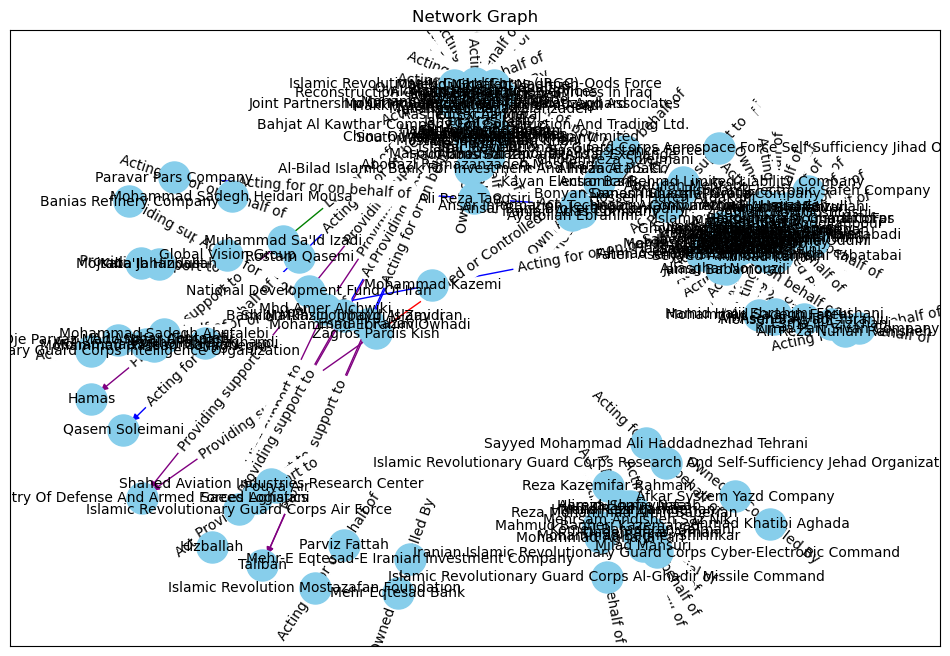

In [7]:
# Initialize the graph
G = nx.DiGraph()  # Directed graph since relationships are directional

# Add edges to the graph
for _, row in df.iterrows():
    G.add_edge(row['entity_1'], row['entity_2'], relationship=row['relationship'])

# Draw the graph with customizations
plt.figure(figsize=(12, 8))

# Position nodes using spring layout
pos = nx.spring_layout(G)

# Define edge colors based on relationship
edge_colors = {'Acting for or on behalf of': 'blue', 'Leader or official of': 'green', 'Owned or Controlled By': 'red', 'Providing support to': 'purple'}
edge_colors_list = [edge_colors[data['relationship']] for _, _, data in G.edges(data=True)]

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_edges(G, pos, edge_color=edge_colors_list)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'relationship')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title('Network Graph')
plt.show()